# Experiment with `Data Assimilation- Observed-simulation ENKF`

In [3]:
import sys 
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')

import Bmi_da_ENKF
import sys

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
#sys.path.append('/Assimilators_FTD/NextGen---The-Simulators-/NextGen---The-Simulators-/USGS/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT/KalmanFilters/NextGen---The-Simulators-/Toy_Model/Assimilation/NextGen---The-Simulators-/USGS/USGS_BMI_FT')
sys.path.insert(0, '../USGS/USGS_BMI_FT')
import bmi_usgs

In [4]:
USGS_instance = bmi_usgs.BMI_USGS()
cfe_instance_peturb = bmi_cfe_peturb.BMI_CFE()
cfe_instance = bmi_cfe.BMI_CFE() #one that changes state vars

print("Input variables:\n")
print("USGS")
print(USGS_instance.get_input_var_names())
print("CFE")
print(cfe_instance_peturb.get_input_var_names())

print("\nOutput variables:")
print(cfe_assimilation.get_output_var_names())
print(USGS_instance.get_output_var_names())

Input variables:

USGS
['sites', 'service', 'start', 'end']
CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']

Output variables:


NameError: name 'cfe_assimilation' is not defined

In [5]:
USGS_instance.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')
cfe_instance_peturb.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')

In [6]:
with open(cfe_instance_peturb.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
#print(df_forcing)

                           Date    Flow  validity
0     2015-11-01 06:00:00+00:00  2.5000       1.0
1     2015-11-01 07:00:00+00:00  2.5000       1.0
2     2015-11-01 08:00:00+00:00  2.5000       1.0
3     2015-11-01 09:00:00+00:00  2.5000       1.0
4     2015-11-01 10:00:00+00:00  2.4925       1.0
...                         ...     ...       ...
10220 2016-12-31 02:00:00+00:00  2.5450       1.0
10221 2016-12-31 03:00:00+00:00  2.6325       1.0
10222 2016-12-31 04:00:00+00:00  2.6325       1.0
10223 2016-12-31 05:00:00+00:00  2.5975       1.0
10224 2016-12-31 06:00:00+00:00  2.5800       1.0

[10225 rows x 3 columns]
USGS station ID 10109000


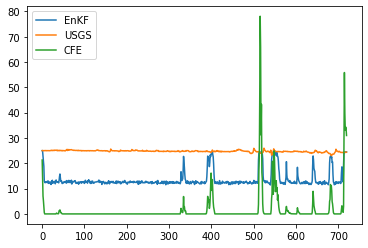

In [9]:
# Make empty matrices for plotting
sim = []
obs = []
cfe = []

############################################
# change this for ENKF
EnKF_results=[]
measurements = []
# Run USG model
USGS_instance.update()
obs = USGS_instance.get_value('Flow')
dim_z=1
dt=1
N=700

# state trans. functions; NEED UPDATE
def hx(x):
    return np.array([x[0]])
def fx(x, dt):
    return F @ x
#####################################################################

for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Run CFE model
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance.update()
    outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe.append(outflow)
    
    # Peturbation run   
    cfe_instance_peturb.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance_peturb.update()
    outflow_peturb = cfe_instance_peturb.get_value('land_surface_water__runoff_depth_ens')
    #print(outflow_peturb)
    # Calculate states of ensemble runs
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_std = np.std(outflow_peturb)
    outflow_peturb_var = np.var(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    
    #obs.append(outflow_peturb_std)
    sim.append(outflow_peturb_mean)#*35.314666212661) # check if the cfs and m3/sec are good.
    
#Assimilation using ENKF
    x=np.array([np.mean(outflow_peturb)])
    P=np.eye(1)*outflow_peturb_covar
    f = Bmi_da_ENKF.EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=dt,N=N, hx=hx, fx=fx)
    f.initialize(x,P) #
    z = np.array([obs[i]])*10
    F = np.array([[1]]) # state transition function
    
    f.predict()
    f.update(z)
    EnKF_results.append(f.x)
    measurements.append(z)

plt.plot(EnKF_results, label='EnKF')
plt.plot(measurements,label='USGS')
plt.plot(sim,label='CFE')
plt.legend(loc=2)